In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [2]:
#hide
from utils import *
setup_chapter()

Using transformers v4.26.0.dev0
Using datasets v2.8.1.dev0


# Multilingual Named Entity Recognition

## The Dataset

In [3]:
#id jeff-dean-ner
#caption An example of a sequence annotated with named entities
#hide_input
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [4]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [5]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [6]:
# hide_output
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

Computing checksums: 100%|##########| 1/1 [00:09<00:00,  9.24s/it]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to L:/HF_DATASETS_CACHE/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [7]:
# hide_output
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to L:/HF_DATASETS_CACHE/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to L:/HF_DATASETS_CACHE/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to L:/HF_DATASETS_CACHE/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [9]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [10]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG',
'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [11]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'],
id=None)


In [12]:
# hide_output
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [13]:
# hide_output
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [14]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Multilingual Transformers

## A Closer Look at Tokenization

In [15]:
# hide_output
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

d:\Anaconda3-2022.05_0802\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in L:\TRANSFORMERS_CACHE. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [16]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [17]:
#hide_input
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### The Tokenizer Pipeline

<img alt="Tokenizer pipeline" caption="The steps in the tokenization pipeline" src="images/chapter04_tokenizer-pipeline.png" id="toknizer-pipeline"/>

### The SentencePiece Tokenizer

In [18]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## Transformers for Named Entity Recognition

<img alt="Architecture of a transformer encoder for classification." caption="Fine-tuning an encoder-based transformer for sequence classification" src="images/chapter04_clf-architecture.png" id="clf-arch"/>

<img alt="Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states." caption="Fine-tuning an encoder-based transformer for named entity recognition" src="images/chapter04_ner-architecture.png" id="ner-arch"/>

## The Anatomy of the Transformers Model Class

### Bodies and Heads

<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="images/chapter04_bert-body-head.png" id="bert-body-head"/>

### Creating a Custom Model for Token Classification

In [19]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### Loading a Custom Model

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
# hide_output
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [22]:
# hide_output
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

In [23]:
# hide_output
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,O,O,O,O,O,O,O,O,B-LOC


In [26]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    

## Tokenizing Texts for NER

In [27]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [28]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [29]:
#hide_output
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [30]:
# hide_output
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [31]:
#hide_output
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [32]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [33]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [34]:
# hide_output
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

## Performance Measures

In [83]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [84]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

In [85]:
# hide_output
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True)

In [86]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\renyu\.huggingface\token


In [87]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [88]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [89]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [90]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [91]:
# hide_output
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

d:\Anaconda3-2022.05_0802\lib\site-packages\huggingface_hub\repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/ryL/xlm-roberta-base-finetuned-panx-de into local empty directory.


In [92]:
#hide_input
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

C:\Users\renyu\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

In [45]:
# hide_input
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\936002055.py:2 in <cell line: 2>               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\936002055.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [46]:
# hide_output
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\24045397.py:3 in <cell line: 3>                │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\24045397.py'                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

## Error Analysis

In [47]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [48]:
# hide_output
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\1873104732.py:3 in <cell line: 3>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\1873104732.py'                         │
│                                                                                                  │
│ C:\Users\renyu\AppData\Roaming\Python\Python39\site-packages\datasets\arrow_dataset.py:2826 in   │
│ map                                                                                              │
│                                                                                                  │
│   2823 │   │   disable_tqdm = not logging.is_progress_bar_enabled()                              │
│   2824 │   │                                                                                     │
│   2825 │   │   if num_proc is None or num_proc == 1:                                             │
│ ❱ 2826 │   │   │   return self._map_single(                                                      │
│   2827 │   │   │   │   function=function,                                                        │
│   2828 │   │   │   │   with_indices=with_indices,                                                │
│   2829 │   │   │   │   with_rank=with_rank,                                                      │
│                                                                                                  │
│ C:\Users\renyu\AppData\Roaming\Python\Python39\site-packages\datasets\arrow_dataset.py:562 in    │
│ wrapper                                                                                          │
│                                                                                                  │
│    559 │   │   else:                                                                             │
│    560 │   │   │   self: "Dataset" = kwargs.pop("self")                                          │
│    561 │   │   # apply actual function                                                           │
│ ❱  562 │   │   out: Union["Dataset", "DatasetDict"] = func(self, *args, **kwargs)                │
│    563 │   │   datasets: List["Dataset"] = list(out.values()) if isinstance(out, dict) else [ou  │
│    564 │   │   for dataset in datasets:                                                          │
│    565 │   │   │   # Remove task templates if a column mapping of the template is no longer val  │
│                                                                                                  │
│ C:\Users\renyu\AppData\Roaming\Python\Python39\site-packages\datasets\arrow_dataset.py:529 in    │
│ wrapper                                                                                          │
│                                                                                                  │
│    526 │   │   │   "output_all_columns": self._output_all_columns,                               │
│    527 │   │   }                                                                                 │
│    528 │   │   # apply actual function                                                           │
│ ❱  529 │   │   out: Union["Dataset", "DatasetDict"] = func(self, *args, **kwargs)                │
│    530 │   │   datasets: List["Dataset"] = list(out.values()) if isinstance(out, dict) else [ou  │
│    531 │   │   # re-apply format to the output                                                   │
│    532 │   │   for dataset in datasets:                                                          │
│                                                                                                  │
│ C:\Users\renyu\AppData\Roaming\Python\Python39\site-package

In [49]:
# hide_output
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3361931715.py:3 in <cell line: 3>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3361931715.py'                         │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\frame.py:3505 in __getitem__             │
│                                                                                                  │
│    3502 │   │   if is_single_key:                                                                │
│    3503 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3504 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3505 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3506 │   │   │   if is_integer(indexer):                                                      │
│    3507 │   │   │   │   indexer = [indexer]                                                      │
│    3508 │   │   else:                                                                            │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\indexes\range.py:389 in get_loc          │
│                                                                                                  │
│    386 │   │   │   │   except ValueError as err:                                                 │
│    387 │   │   │   │   │   raise KeyError(key) from err                                          │
│    388 │   │   │   self._check_indexing_error(key)                                               │
│ ❱  389 │   │   │   raise KeyError(key)                                                           │
│    390 │   │   return super().get_loc(key, method=method, tolerance=tolerance)                   │
│    391 │                                                                                         │
│    392 │   def _get_indexer(                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'input_ids'

In [50]:
# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\computation\scope.py:195 in resolve      │
│                                                                                                  │
│   192 │   │   │                                                                                  │
│   193 │   │   │   # not a local variable so check in resolvers if we have them                   │
│   194 │   │   │   if self.has_resolvers:                                                         │
│ ❱ 195 │   │   │   │   return self.resolvers[key]                                                 │
│   196 │   │   │                                                                                  │
│   197 │   │   │   # if we're here that means that we have no locals and we also have             │
│   198 │   │   │   # no resolvers                                                                 │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\collections\__init__.py:941 in __getitem__                         │
│                                                                                                  │
│    938 │   │   │   │   return mapping[key]             # can't use 'key in mapping' with defaul  │
│    939 │   │   │   except KeyError:                                                              │
│    940 │   │   │   │   pass                                                                      │
│ ❱  941 │   │   return self.__missing__(key)            # support subclasses that define __missi  │
│    942 │                                                                                         │
│    943 │   def get(self, key, default=None):                                                     │
│    944 │   │   return self[key] if key in self else default                                      │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\collections\__init__.py:933 in __missing__                         │
│                                                                                                  │
│    930 │   │   self.maps = list(maps) or [{}]          # always at least one map                 │
│    931 │                                                                                         │
│    932 │   def __missing__(self, key):                                                           │
│ ❱  933 │   │   raise KeyError(key)                                                               │
│    934 │                                                                                         │
│    935 │   def __getitem__(self, key):                                                           │
│    936 │   │   for mapping in self.maps:                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'labels'

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\computation\scope.py:206 in resolve      │
│                                                                                                  │
│   203 │   │   │   │   # last ditch effort we look in temporaries                                 │
│   204 │   │   │   │   # these are created when parsing indexing expressions                      │
│   205 │   │   │   │   # e.g., df[df > 0]                                                         │
│ ❱ 206 │   │   │   │   return self.temps[key]                                                     │
│   207 │   │   │   except KeyError as err:                              

In [51]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\1017739013.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\1017739013.py'                         │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\frame.py:7712 in groupby                 │
│                                                                                                  │
│    7709 │   │   # https://github.com/python/mypy/issues/7642                                     │
│    7710 │   │   # error: Argument "squeeze" to "DataFrameGroupBy" has incompatible type          │
│    7711 │   │   # "Union[bool, NoDefault]"; expected "bool"                                      │
│ ❱  7712 │   │   return DataFrameGroupBy(                                                         │
│    7713 │   │   │   obj=self,                                                                    │
│    7714 │   │   │   keys=by,                                                                     │
│    7715 │   │   │   axis=axis,                                                                   │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\groupby\groupby.py:882 in __init__       │
│                                                                                                  │
│    879 │   │   if grouper is None:                                                               │
│    880 │   │   │   from pandas.core.groupby.grouper import get_grouper                           │
│    881 │   │   │                                                                                 │
│ ❱  882 │   │   │   grouper, exclusions, obj = get_grouper(                                       │
│    883 │   │   │   │   obj,                                                                      │
│    884 │   │   │   │   keys,                                                                     │
│    885 │   │   │   │   axis=axis,                                                                │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\groupby\grouper.py:882 in get_grouper    │
│                                                                                                  │
│   879 │   │   │   elif obj._is_level_reference(gpr, axis=axis):                                  │
│   880 │   │   │   │   in_axis, level, gpr = False, gpr, None                                     │
│   881 │   │   │   else:                                                                          │
│ ❱ 882 │   │   │   │   raise KeyError(gpr)                                                        │
│   883 │   │   elif isinstance(gpr, Grouper) and gpr.key is not None:                             │
│   884 │   │   │   # Add key to exclusions                                                        │
│   885 │   │   │   exclusions.add(gpr.key)                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'input_tokens'

In [52]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\1651211442.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\1651211442.py'                         │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\frame.py:7712 in groupby                 │
│                                                                                                  │
│    7709 │   │   # https://github.com/python/mypy/issues/7642                                     │
│    7710 │   │   # error: Argument "squeeze" to "DataFrameGroupBy" has incompatible type          │
│    7711 │   │   # "Union[bool, NoDefault]"; expected "bool"                                      │
│ ❱  7712 │   │   return DataFrameGroupBy(                                                         │
│    7713 │   │   │   obj=self,                                                                    │
│    7714 │   │   │   keys=by,                                                                     │
│    7715 │   │   │   axis=axis,                                                                   │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\groupby\groupby.py:882 in __init__       │
│                                                                                                  │
│    879 │   │   if grouper is None:                                                               │
│    880 │   │   │   from pandas.core.groupby.grouper import get_grouper                           │
│    881 │   │   │                                                                                 │
│ ❱  882 │   │   │   grouper, exclusions, obj = get_grouper(                                       │
│    883 │   │   │   │   obj,                                                                      │
│    884 │   │   │   │   keys,                                                                     │
│    885 │   │   │   │   axis=axis,                                                                │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\groupby\grouper.py:882 in get_grouper    │
│                                                                                                  │
│   879 │   │   │   elif obj._is_level_reference(gpr, axis=axis):                                  │
│   880 │   │   │   │   in_axis, level, gpr = False, gpr, None                                     │
│   881 │   │   │   else:                                                                          │
│ ❱ 882 │   │   │   │   raise KeyError(gpr)                                                        │
│   883 │   │   elif isinstance(gpr, Grouper) and gpr.key is not None:                             │
│   884 │   │   │   # Add key to exclusions                                                        │
│   885 │   │   │   exclusions.add(gpr.key)                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'labels'

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [54]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\4140690870.py:1 in <cell line: 1>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\4140690870.py'                         │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\frame.py:3505 in __getitem__             │
│                                                                                                  │
│    3502 │   │   if is_single_key:                                                                │
│    3503 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3504 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3505 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3506 │   │   │   if is_integer(indexer):                                                      │
│    3507 │   │   │   │   indexer = [indexer]                                                      │
│    3508 │   │   else:                                                                            │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\indexes\range.py:389 in get_loc          │
│                                                                                                  │
│    386 │   │   │   │   except ValueError as err:                                                 │
│    387 │   │   │   │   │   raise KeyError(key) from err                                          │
│    388 │   │   │   self._check_indexing_error(key)                                               │
│ ❱  389 │   │   │   raise KeyError(key)                                                           │
│    390 │   │   return super().get_loc(key, method=method, tolerance=tolerance)                   │
│    391 │                                                                                         │
│    392 │   def _get_indexer(                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'labels'

In [55]:
# hide_output
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\178431694.py:15 in <cell line: 15>             │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\178431694.py'                          │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\frame.py:3505 in __getitem__             │
│                                                                                                  │
│    3502 │   │   if is_single_key:                                                                │
│    3503 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3504 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3505 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3506 │   │   │   if is_integer(indexer):                                                      │
│    3507 │   │   │   │   indexer = [indexer]                                                      │
│    3508 │   │   else:                                                                            │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\indexes\range.py:389 in get_loc          │
│                                                                                                  │
│    386 │   │   │   │   except ValueError as err:                                                 │
│    387 │   │   │   │   │   raise KeyError(key) from err                                          │
│    388 │   │   │   self._check_indexing_error(key)                                               │
│ ❱  389 │   │   │   raise KeyError(key)                                                           │
│    390 │   │   return super().get_loc(key, method=method, tolerance=tolerance)                   │
│    391 │                                                                                         │
│    392 │   def _get_indexer(                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'loss'

In [56]:
# hide_output
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\4244230352.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\4244230352.py'                         │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\frame.py:3505 in __getitem__             │
│                                                                                                  │
│    3502 │   │   if is_single_key:                                                                │
│    3503 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3504 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3505 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3506 │   │   │   if is_integer(indexer):                                                      │
│    3507 │   │   │   │   indexer = [indexer]                                                      │
│    3508 │   │   else:                                                                            │
│                                                                                                  │
│ d:\Anaconda3-2022.05_0802\lib\site-packages\pandas\core\indexes\range.py:389 in get_loc          │
│                                                                                                  │
│    386 │   │   │   │   except ValueError as err:                                                 │
│    387 │   │   │   │   │   raise KeyError(key) from err                                          │
│    388 │   │   │   self._check_indexing_error(key)                                               │
│ ❱  389 │   │   │   raise KeyError(key)                                                           │
│    390 │   │   return super().get_loc(key, method=method, tolerance=tolerance)                   │
│    391 │                                                                                         │
│    392 │   def _get_indexer(                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'input_tokens'

## Cross-Lingual Transfer

In [57]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [58]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3207825035.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3207825035.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [59]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\1041526804.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\1041526804.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [60]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [61]:
# hide_output
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\860253607.py:2 in <cell line: 2>               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\860253607.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [62]:
# hide_input
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3959236737.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3959236737.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'fr'

In [63]:
# hide_output
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\1564635093.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\1564635093.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [64]:
# hide_input
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\1482194595.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\1482194595.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'it'

In [65]:
#hide_output
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3110295054.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3110295054.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [66]:
#hide_input
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\4161675145.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\4161675145.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'en'

### When Does Zero-Shot Transfer Make Sense?

In [67]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [68]:
# hide_output
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [69]:
# hide_output
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\2565921835.py:3 in <cell line: 3>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\2565921835.py'                         │
│                                                                                                  │
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\513252311.py:8 in train_on_subset              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\513252311.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'compute_metrics' is not defined

In [70]:
#hide_input
# Hack needed to exclude the progress bars in the above cell
metrics_df

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\2447813351.py:3 in <cell line: 3>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\2447813351.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'metrics_df' is not defined

In [71]:
# hide_output
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3920662034.py:3 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3920662034.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'metrics_df' is not defined

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\2454113888.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\2454113888.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'fr'

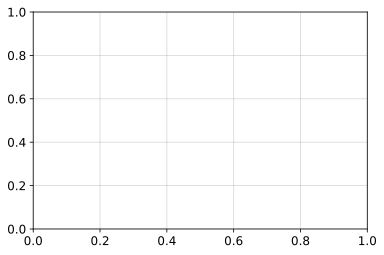

In [72]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### Fine-Tuning on Multiple Languages at Once

In [73]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [74]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [75]:
# hide_output
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3010224563.py:7 in <cell line: 6>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3010224563.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'compute_metrics' is not defined

In [76]:
#hide_output
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\2694716555.py:3 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\2694716555.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [77]:
#hide_input
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3531064292.py:3 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3531064292.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [78]:
# hide_output
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\1334113973.py:9 in <cell line: 5>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\1334113973.py'                         │
│                                                                                                  │
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\513252311.py:8 in train_on_subset              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\513252311.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'compute_metrics' is not defined

In [79]:
corpora_encoded = concatenate_splits(corpora)

In [80]:
# hide_output
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3143681109.py:6 in <cell line: 5>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3143681109.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'compute_metrics' is not defined

In [81]:
# hide_output
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\3406491284.py:3 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\3406491284.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

In [82]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\4218146796.py:2 in <cell line: 1>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\4218146796.py'                         │
│                                                                                                  │
│ C:\Users\renyu\AppData\Local\Temp\ipykernel_43700\4218146796.py:2 in <dictcomp>                  │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\renyu\\AppData\\Local\\Temp\\ipykernel_43700\\4218146796.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'de'

## Interacting with Model Widgets

<img alt="A Hub widget" caption="Example of a widget on the Hugging Face Hub" src="images/chapter04_ner-widget.png" id="ner-widget"/>  

## Conclusion